# Plots for the FAR.AI work trial

## Setup

In [1]:
from dataclasses import dataclass
from typing import Literal, Iterable
from pathlib import Path
import pickle
from collections import defaultdict

import numpy as np

import wandb

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from nip.utils.nested_array_dict import NestedArrayDict
from nip.utils.maths import aggregate_mean_grouped_by_class
from nip.constants import ROLLOUTS_ARTIFACT_PREFIX, ROLLOUTS_ARTIFACT_TYPE

In [2]:
api = wandb.Api()

In [3]:
IGNORE_CACHE = False

WANDB_PROJECT = "sam-adam-day-work-trial"
WANDB_ENTITY = "farai"

In [4]:
COLOURS = ["#332288", "#CC6677", "#88CCEE", "#117733", "#44AA99", "#DDCC77", "#999933", "#882255", "#AA4499", "#DDDDDD"]

In [5]:
ALL_PERSONAS = [
    "Overconfident Expert",
    "Charming Optimist",
    "Evasive Trickster",
    "Apologetic Underachiever",
    "Infallible Narrator",
    "Technical Minimalist",
    "Distractor",
    "Defensive Guru",
    "Quixotic Idealist",
    "Peer Reviewer",
]
SELECTED_PERSONAS = [
    "Charming Optimist",
    "Infallible Narrator",
    "Technical Minimalist",
    "Defensive Guru",
    "Peer Reviewer",
]
VERIFIER_MODELS = {
    0.5: "Qwen2.5-0.5B-Instruct",
    1.5: "Qwen2.5-1.5B-Instruct",
    3: "Qwen2.5-3B-Instruct",
    7: "Qwen2.5-7B-Instruct",
    14: "Qwen2.5-14B-Instruct",
    32: "Qwen2.5-32B-Instruct",
}
# SELECTED_PROMPT_TEMPLATES = [
#     "Charming Optimist",
#     "Infallible Narrator",
# ]
# VERIFIER_MODELS = {
#     0.5: "Qwen2.5-0.5B-Instruct",
# }

In [6]:
SOLO_VERIFIER_COLOUR = COLOURS[0]
STANDARD_PERSONA_COLOUR = COLOURS[1]
PERSONA_COLOURS = {
    persona: COLOURS[i+2] for i, persona in enumerate(SELECTED_PERSONAS)
}
NEUTRAL_LINE_COLOUR = "#333333"
NEUTRAL_BAR_COLOUR = "#cccccc"

## Load and process rollouts

### Initialise

In [ ]:
# Stats for exploring personas with a 7B verifier
pe7_stats = {
    "accuracy_per_persona": {},
    "acceptance_rate_per_persona": {},
    "TNR_per_persona": {},
}

# Stats for the scaling law experiment with 72B prover and different personas
sl72_stats = {
    "accuracy_per_model_per_persona": defaultdict(dict),
    "acceptance_rate_per_model_per_persona": defaultdict(dict),
    "TNR_per_model_per_persona": defaultdict(dict),
    "worst_TNR_per_model": {},
}

# Stats for the scaling law experiment with 72B prover and standard persona
sls72_stats = {
    "accuracy_per_model": {},
    "acceptance_rate_per_model": {},
    "TNR_per_model": {},
    "TNR_worst_case_rate": {}
}

# Stats for the scaling law experiment with solo verifiers
s_stats = {
    "accuracy_per_model": {},
    "acceptance_rate_per_model": {},
    "TNR_per_model": {},
    "TNR_worst_case_rate": {}
}

### Functions for loading and processing

In [8]:
def load_rollouts(run_id: str, iteration_name: str = "test_0") -> NestedArrayDict:
    rollout_artifact = api.artifact(
        f"{WANDB_ENTITY}/{WANDB_PROJECT}/{ROLLOUTS_ARTIFACT_PREFIX}{run_id}:latest",
        ROLLOUTS_ARTIFACT_TYPE,
    )
    artifact_path = Path(f"cache/wt_full_rollouts/{run_id}/")
    if not artifact_path.exists() or IGNORE_CACHE:
        artifact_path.mkdir(exist_ok=True, parents=True)
        rollout_artifact.download(artifact_path)
    with open(artifact_path.joinpath(f"{iteration_name}.pt"), "rb") as f:
        return pickle.load(f)

In [9]:
def compute_mean_accuracy(rollouts: NestedArrayDict) -> float:
    next_done = rollouts["next", "done"]
    next_terminated = rollouts["next", "terminated"]
    padding = rollouts["padding"]
    last_timestep = (next_done | next_terminated) & ~padding
    verifier_decision = rollouts["agents", "decision"][..., -1]
    correct = verifier_decision[last_timestep] == rollouts["y"][last_timestep]
    return correct.mean().item()

In [10]:
def compute_acceptance_rate(rollouts: NestedArrayDict) -> float:
    next_done = rollouts["next", "done"]
    next_terminated = rollouts["next", "terminated"]
    padding = rollouts["padding"]
    last_timestep = (next_done | next_terminated) & ~padding
    verifier_decision = rollouts["agents", "decision"][..., -1]
    return (verifier_decision[last_timestep] == 1).mean().item()

In [11]:
def compute_mean_accuracy_per_datapoint(
    rollouts: NestedArrayDict,
    only_extant_datapoints: bool = True,
    only_negative: bool = False,
) -> np.ndarray:
    next_done = rollouts["next", "done"]
    next_terminated = rollouts["next", "terminated"]
    padding = rollouts["padding"]
    datapoint_id = rollouts["datapoint_id"][..., 0]
    last_timestep = (next_done | next_terminated) & ~padding
    verifier_decision = rollouts["agents", "decision"][..., -1]
    accuracy = verifier_decision[last_timestep] == rollouts["y"][last_timestep]
    if only_negative:
        accuracy = accuracy[rollouts["y"][last_timestep] == 0]
        datapoint_id = datapoint_id[rollouts["y"][last_timestep] == 0]
    aggregate_mean = aggregate_mean_grouped_by_class(
        accuracy.astype(float), datapoint_id
    )
    if only_extant_datapoints:
        aggregate_mean = aggregate_mean[~np.isnan(aggregate_mean)]
    return aggregate_mean

### Compute stats for exploring personas with a 7B verifier

In [12]:
for persona_index, persona in enumerate(ALL_PERSONAS):
    rollouts = load_rollouts(
        f"ei_cv_qwen2.5_7B_72B_chatgpt_prompts_{persona_index}", "0"
    )
    pe7_stats["accuracy_per_persona"][persona] = compute_mean_accuracy(rollouts)
    pe7_stats["acceptance_rate_per_persona"][persona] = compute_acceptance_rate(
        rollouts
    )
    tnr = compute_mean_accuracy_per_datapoint(rollouts, only_negative=True)
    pe7_stats["TNR_per_persona"][persona] = np.mean(tnr).item()

### Compute stats for the scaling law experiment with 72B prover and standard persona

In [15]:
for verifier_model_size in tqdm(VERIFIER_MODELS.keys()):
    rollouts = load_rollouts(f"ei_cv_standard_qwen2.5_{verifier_model_size}B_72B_0")
    sls72_stats["accuracy_per_model"][verifier_model_size] = compute_mean_accuracy(
        rollouts
    )
    sls72_stats["acceptance_rate_per_model"][verifier_model_size] = (
        compute_acceptance_rate(rollouts)
    )
    tnr = compute_mean_accuracy_per_datapoint(rollouts, only_negative=True)
    sls72_stats["TNR_per_model"][verifier_model_size] = np.mean(tnr).item()
    sls72_stats["TNR_worst_case_rate"][verifier_model_size] = (tnr == 0).mean().item()

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]wandb: Downloading large artifact full_rollouts_ei_cv_standard_qwen2.5_1.5B_72B_0:latest, 150.66MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:21.5
 33%|███▎      | 2/6 [00:23<00:54, 13.64s/it]wandb: Downloading large artifact full_rollouts_ei_cv_standard_qwen2.5_3B_72B_0:latest, 94.12MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:12.9
 50%|█████     | 3/6 [00:37<00:41, 13.77s/it]wandb: Downloading large artifact full_rollouts_ei_cv_standard_qwen2.5_7B_72B_0:latest, 158.49MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:21.7
 67%|██████▋   | 4/6 [01:00<00:34, 17.32s/it]wandb: Downloading large artifact full_rollouts_ei_cv_standard_qwen2.5_14B_72B_0:latest, 149.41MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:20.9
 83%|████████▎ | 5/6 [01:22<00:18, 18.99s/it]wandb: Downloading large artifact full_rollouts_ei_cv_standard_qwen2.5_32B_72B_0:latest, 149.70MB. 2 files... 
wandb:   2 of 2 fi

### Compute stats for the scaling law experiment with 72B prover and different personas

In [16]:
for verifier_model_size in tqdm(VERIFIER_MODELS.keys()):
    tnr_per_datapoint = {}
    for persona_index, persona in enumerate(SELECTED_PERSONAS):
        rollouts = load_rollouts(
            f"ei_cv_qwen2.5_{verifier_model_size}B_72B_"
            f"chatgpt_prompts_test_2_{persona_index}"
        )
        sl72_stats["accuracy_per_model_per_persona"][verifier_model_size][
            persona
        ] = compute_mean_accuracy(rollouts)
        sl72_stats["acceptance_rate_per_model_per_persona"][verifier_model_size][
            persona
        ] = compute_acceptance_rate(rollouts)
        tnr_per_datapoint[persona] = compute_mean_accuracy_per_datapoint(
            rollouts, only_negative=True
        )
        sl72_stats["TNR_per_model_per_persona"][verifier_model_size][
            persona
        ] = np.mean(tnr_per_datapoint[persona]).item()
    worst_tnr_per_datapoint = np.min(
        np.array(list(tnr_per_datapoint.values())), axis=0
    )
    sl72_stats["worst_TNR_per_model"][verifier_model_size] = np.mean(
        worst_tnr_per_datapoint
    ).item()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:20<00:00,  3.46s/it]


### Compute stats for the scaling law experiment with solo verifiers

In [28]:
s_run_ids = {
    0.5: "ei_cv_solo_qwen2.5_0.5B_0",
    1.5: "ei_cv_solo_qwen2.5_1.5B_0",
    3: "ei_cv_solo_qwen2.5_3B_2_0",
    7: "ei_cv_solo_qwen2.5_7B_2_0",
    14: "ei_cv_solo_qwen2.5_14B_0",
    32: "ei_cv_solo_qwen2.5_32B_0",
}

# for verifier_model_size in tqdm(VERIFIER_MODELS.keys()):
for verifier_model_size, run_id in tqdm(s_run_ids.items()):
    rollouts = load_rollouts(run_id)
    s_stats["accuracy_per_model"][verifier_model_size] = compute_mean_accuracy(rollouts)
    s_stats["acceptance_rate_per_model"][verifier_model_size] = (
        compute_acceptance_rate(rollouts)
    )
    tnr = compute_mean_accuracy_per_datapoint(rollouts, only_negative=True)
    s_stats["TNR_per_model"][verifier_model_size] = np.mean(tnr).item()
    s_stats["TNR_worst_case_rate"][verifier_model_size] = (tnr == 0).mean().item()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


## Plots

In [34]:
INCLUDE_SOLO_VERIFIER = False
INCLUDE_STANDARD_PERSONA = True

### Worst-case TNR proportion per model

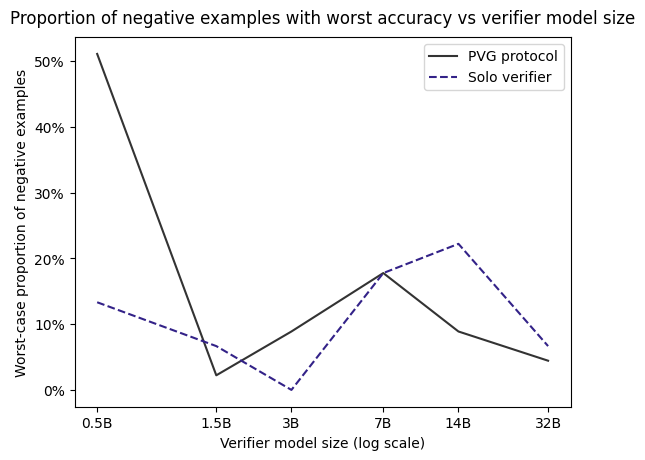

In [ ]:
INCLUDE_SOLO_VERIFIER = True

fig, ax = plt.subplots()

ax.plot(
    [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
    [
        sls72_stats["TNR_worst_case_rate"][verifier_model_size]
        for verifier_model_size in VERIFIER_MODELS.keys()
    ],
    color=NEUTRAL_LINE_COLOUR,
)

if INCLUDE_SOLO_VERIFIER:
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            s_stats["TNR_worst_case_rate"][verifier_model_size]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        color=SOLO_VERIFIER_COLOUR,
        linestyle="--",
    )

ax.set_title("Proportion of negative examples with worst accuracy vs verifier model size", pad=10)
ax.set_xlabel("Verifier model size (log scale)")
ax.set_ylabel("Worst-case proportion of negative examples")
ax.set_xscale("log")
ax.set_xticks([model_size * 10**9 for model_size in VERIFIER_MODELS.keys()])
ax.set_xticklabels([f"{model_size}B" for model_size in VERIFIER_MODELS.keys()])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

if INCLUDE_SOLO_VERIFIER:
    ax.legend(
        [
            "PVG protocol",
            "Solo verifier",
        ],
        loc="upper right",
    )

plt.show()

### TNR for all personas on 7B

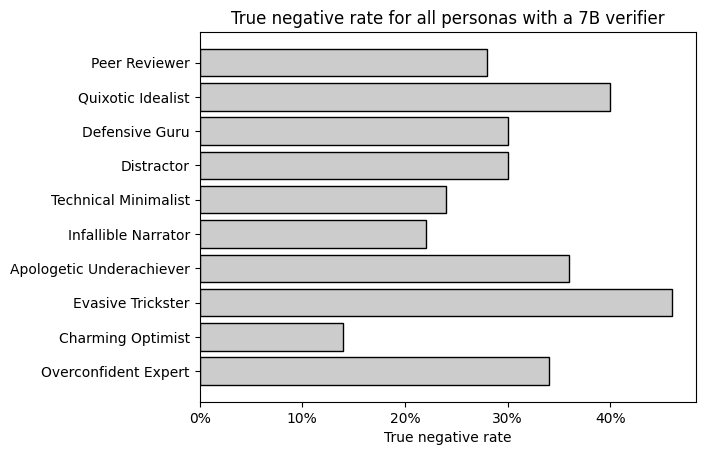

In [20]:
fig, ax = plt.subplots()

personas = list(pe7_stats["TNR_per_persona"].keys())
accuracies = list(pe7_stats["TNR_per_persona"].values())

ax.barh(personas, accuracies, color=NEUTRAL_BAR_COLOUR, edgecolor="black")

ax.set_title("True negative rate for all personas with a 7B verifier")
ax.set_xlabel("True negative rate")
# ax.set_ylabel("Persona")
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))

plt.show()

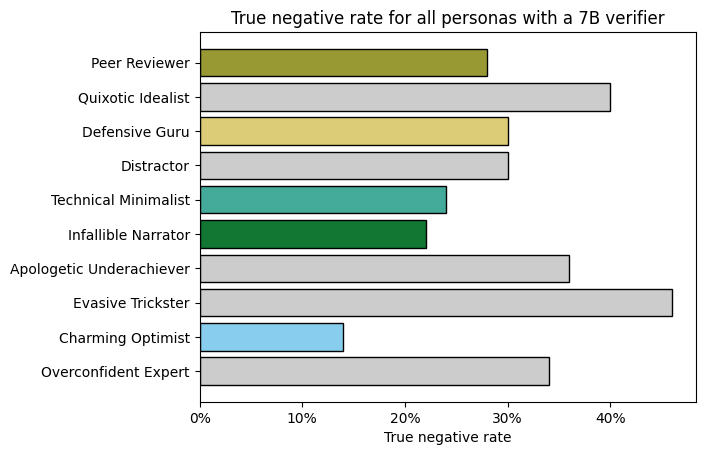

In [21]:
fig, ax = plt.subplots()

personas = list(pe7_stats["TNR_per_persona"].keys())
accuracies = list(pe7_stats["TNR_per_persona"].values())

colours = [NEUTRAL_BAR_COLOUR] * len(personas)
for persona_index, persona in enumerate(ALL_PERSONAS):
    if persona in SELECTED_PERSONAS:
        colours[persona_index] = PERSONA_COLOURS[persona]

ax.barh(personas, accuracies, color=colours, edgecolor="black")

ax.set_title("True negative rate for all personas with a 7B verifier")
ax.set_xlabel("True negative rate")
# ax.set_ylabel("Persona")
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))

plt.show()

### TPR per model per persona

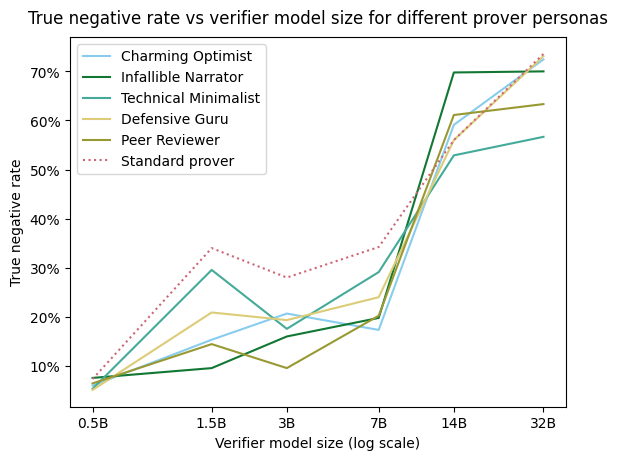

In [ ]:
INCLUDE_SOLO_VERIFIER = False
INCLUDE_STANDARD_PERSONA = True

fig, ax = plt.subplots()

for persona_index, persona in enumerate(SELECTED_PERSONAS):
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            sl72_stats["TNR_per_model_per_persona"][verifier_model_size][persona]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label=persona,
        color=PERSONA_COLOURS[persona],
    )

if INCLUDE_STANDARD_PERSONA:
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            sls72_stats["TNR_per_model"][verifier_model_size]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label="Standard prover",
        color=STANDARD_PERSONA_COLOUR,
        linestyle=':'
    )

if INCLUDE_SOLO_VERIFIER:
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            s_stats["TNR_per_model"][verifier_model_size]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label="Solo verifier",
        color=SOLO_VERIFIER_COLOUR,
        linestyle='--'
    )

ax.set_title("True negative rate vs verifier model size for different prover personas", pad=10)
ax.set_xlabel("Verifier model size (log scale)")
ax.set_ylabel("True negative rate")
ax.set_xscale("log")
ax.set_xticks([model_size * 10**9 for model_size in VERIFIER_MODELS.keys()])
ax.set_xticklabels([f"{model_size}B" for model_size in VERIFIER_MODELS.keys()])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.legend()
plt.show()

### Accuracy per model per persona

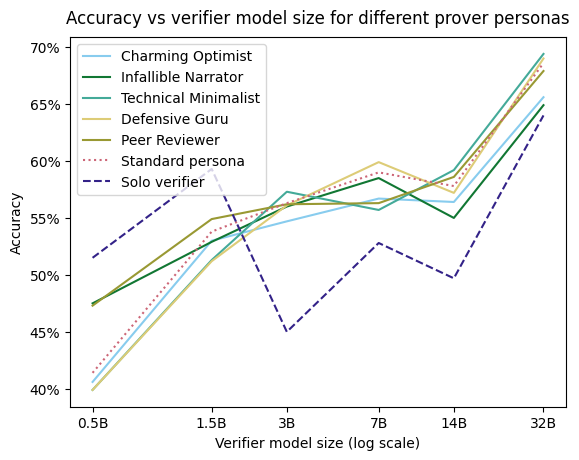

In [40]:
INCLUDE_SOLO_VERIFIER = True
INCLUDE_STANDARD_PERSONA = True

fig, ax = plt.subplots()

for persona_index, persona in enumerate(SELECTED_PERSONAS):
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            sl72_stats["accuracy_per_model_per_persona"][verifier_model_size][persona]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label=persona,
        color=PERSONA_COLOURS[persona],
    )

if INCLUDE_STANDARD_PERSONA:
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            sls72_stats["accuracy_per_model"][verifier_model_size]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label="Standard persona",
        color=STANDARD_PERSONA_COLOUR,
        linestyle=':'
    )

if INCLUDE_SOLO_VERIFIER:
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            s_stats["accuracy_per_model"][verifier_model_size]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label="Solo verifier",
        color=SOLO_VERIFIER_COLOUR,
        linestyle='--'
    )

ax.set_title("Accuracy vs verifier model size for different prover personas", pad=10)
ax.set_xlabel("Verifier model size (log scale)")
ax.set_ylabel("Accuracy")
ax.set_xscale("log")
ax.set_xticks([model_size * 10**9 for model_size in VERIFIER_MODELS.keys()])
ax.set_xticklabels([f"{model_size}B" for model_size in VERIFIER_MODELS.keys()])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

ax.legend()
plt.show()

### Acceptance rate per model per persona

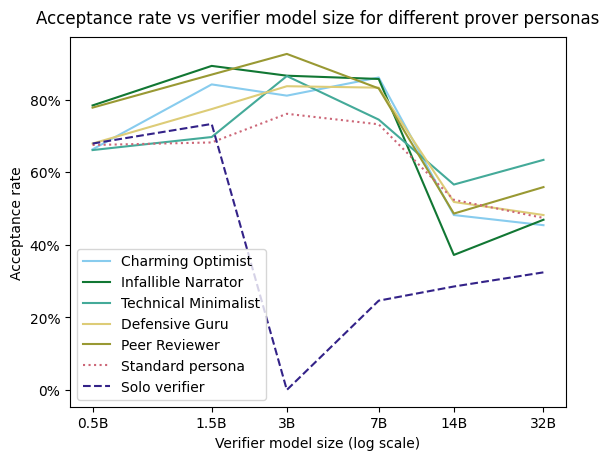

In [41]:
INCLUDE_SOLO_VERIFIER = True
INCLUDE_STANDARD_PERSONA = True

fig, ax = plt.subplots()

for persona_index, persona in enumerate(SELECTED_PERSONAS):
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            sl72_stats["acceptance_rate_per_model_per_persona"][verifier_model_size][persona]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label=persona,
        color=PERSONA_COLOURS[persona],
    )

if INCLUDE_STANDARD_PERSONA:
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            sls72_stats["acceptance_rate_per_model"][verifier_model_size]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label="Standard persona",
        color=STANDARD_PERSONA_COLOUR,
        linestyle=':'
    )

if INCLUDE_SOLO_VERIFIER:
    ax.plot(
        [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
        [
            s_stats["acceptance_rate_per_model"][verifier_model_size]
            for verifier_model_size in VERIFIER_MODELS.keys()
        ],
        label="Solo verifier",
        color=SOLO_VERIFIER_COLOUR,
        linestyle='--'
    )

ax.set_title("Acceptance rate vs verifier model size for different prover personas", pad=10)
ax.set_xlabel("Verifier model size (log scale)")
ax.set_ylabel("Acceptance rate")
ax.set_xscale("log")
ax.set_xticks([model_size * 10**9 for model_size in VERIFIER_MODELS.keys()])
ax.set_xticklabels([f"{model_size}B" for model_size in VERIFIER_MODELS.keys()])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

ax.legend()
plt.show()

### Worst TNR per model

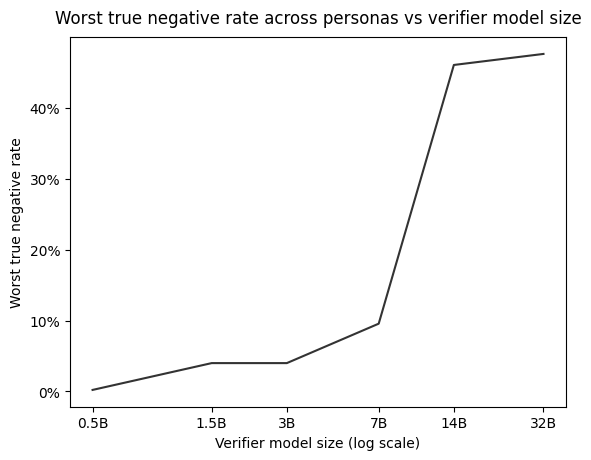

In [25]:
fig, ax = plt.subplots()

ax.plot(
    [model_size * 10**9 for model_size in VERIFIER_MODELS.keys()],
    [
        sl72_stats["worst_TNR_per_model"][verifier_model_size]
        for verifier_model_size in VERIFIER_MODELS.keys()
    ],
    color=NEUTRAL_LINE_COLOUR,
)

ax.set_title("Worst true negative rate across personas vs verifier model size", pad=10)
ax.set_xlabel("Verifier model size (log scale)")
ax.set_ylabel("Worst true negative rate")
ax.set_xscale("log")
ax.set_xticks([model_size * 10**9 for model_size in VERIFIER_MODELS.keys()])
ax.set_xticklabels([f"{model_size}B" for model_size in VERIFIER_MODELS.keys()])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

plt.show()